# Data Preprocessing

## Crime(보이스피싱) Data
- 분석 대상지역 : 대전광역시, 세종시

In [4]:
# package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from tqdm import tqdm

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

In [5]:
# csv load(7.1s)
KP2020 = pd.read_csv('data/KP2020.csv', encoding='cp949')
KP2021 = pd.read_csv('data/KP2021.csv', encoding='cp949')
NPA2020 = pd.read_csv('data/NPA2020.csv', encoding='cp949')

### 보이스피싱 범죄 Dataset Generate
- 사건코드 : EVT_CL_CD == 215 </br>
- 동일사건 제외 : SME_EVT_YN != Y

In [6]:
KP2020 = KP2020.loc[(KP2020.EVT_CL_CD == 215) & (KP2020.SME_EVT_YN != 'Y'),:]
KP2021 = KP2021.loc[(KP2021.EVT_CL_CD == 215) & (KP2021.SME_EVT_YN != 'Y'),:]
NPA2020 = NPA2020.loc[(NPA2020.EVT_CL_CD == 215) & (NPA2020.SME_EVT_YN != 'Y'),:]

In [7]:
# Datetime 통일
NPA2020['RECV_CPLT_DM'] = None
NPA2020['RECV_CPLT_DM'] = NPA2020['RECV_CPLT_DM'].astype('str')
NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype('str')
NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype('str')

NPA2020['RECV_CPLT_DM'] = [i + j.zfill(6) for i,j in NPA2020[['RECV_CPLT_DT','RECV_CPLT_TM']].values] # 시간 6자리로 코딩 후 병합
NPA2020 = NPA2020[NPA2020.columns.drop(['RECV_CPLT_DT','RECV_CPLT_TM'])]

In [8]:
KP2020['RECV_CPLT_DM'] = pd.to_datetime(KP2020['RECV_CPLT_DM'], yearfirst=True)
KP2021['RECV_CPLT_DM'] = pd.to_datetime(KP2021['RECV_CPLT_DM'], yearfirst=True)
NPA2020['RECV_CPLT_DM'] = pd.to_datetime(NPA2020['RECV_CPLT_DM'], yearfirst=True)

In [9]:
# 사용컬럼만 추출
cols = ['RECV_CPLT_DM', 'NPA_CL', 'RPTER_SEX', 'HPPN_X', 'HPPN_Y']
KP2020 = KP2020[cols]
KP2021 = KP2021[cols]
NPA2020 = NPA2020[cols]

In [10]:
# Merge
df_crime = pd.concat([KP2020, KP2021, NPA2020], axis=0).dropna(axis=0).sort_values(by='RECV_CPLT_DM')
df_crime = df_crime[~(df_crime.HPPN_X == 0)].reset_index(drop=True)

# to GeoDataFrame
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime['HPPN_X'], df_crime['HPPN_Y']), crs='WGS84')
gdf_crime = gdf_crime[gdf_crime.columns.drop(['HPPN_X','HPPN_Y'])]

In [11]:
gdf_crime = gdf_crime.loc[(gdf_crime.RECV_CPLT_DM < pd.to_datetime('2022-01-01')) & (pd.to_datetime('2021-01-01') <= gdf_crime.RECV_CPLT_DM), :] # 2021년 데이터만 추출

In [12]:
gdf_crime = gdf_crime.loc[gdf_crime.NPA_CL.isin([13,31]),:] # 충남(19) 제외, 세종(31), 대전(13) 한정 데이터 추출
gdf_crime = gdf_crime.to_crs(epsg=5181)

gdf_crime.to_file('data/gdf_crime_full.gpkg',index=False)

gdf_crime_DJ = gdf_crime.loc[gdf_crime.NPA_CL == 13, : ]
gdf_crime_SJ = gdf_crime.loc[gdf_crime.NPA_CL == 31, : ]
gdf_crime_DJ.to_file('data/gdf_crime_DJ.gpkg', index=False)
gdf_crime_SJ.to_file('data/gdf_crime_SJ.gpkg', index=False)

## Geographic Processing

### 행정구역

In [13]:
gdf_crime = gpd.read_file('data/gdf_crime_full.gpkg')

In [16]:
# 행정구역 data
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949')
sejong = sejong.to_crs(epsg=5181)
sejong['시도'] = '세종'

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949')
daejeon = daejeon.to_crs(epsg=5181)
daejeon['시도'] = '대전'

# chungnam = gpd.read_file('data/ADM_AREA/충남/LSMD_ADM_SECT_UMD_44.shp', encoding='cp949')
# chungnam = chungnam.to_crs(epsg=5181)
# chungnam['시도'] = '충남'
# chungnam.total_bounds

In [17]:
# # 충남지역은 도서지역이 포함되므로 육지(태안군 소원면까지를 왼쪽 기준으로 잡음)만 행정구역으로 사용
# from shapely.geometry import MultiPolygon
# from operator import itemgetter

# 소원면 = chungnam.loc[chungnam.EMD_NM == '소원면','geometry']
# xmin, _, _, _ = 소원면.total_bounds
# dropls = []
# for i,g_i in enumerate(tqdm(chungnam.geometry)):
#     if type(g_i) == MultiPolygon:
#         keep_i = list(range(len(g_i.geoms)))
#         for j, g_j in enumerate(g_i.geoms):
#             if g_j.bounds[0] < xmin:
#                 keep_i.remove(j)
        
#         chungnam.geometry[i] = MultiPolygon(list(itemgetter(*keep_i)(g_i.geoms)))
#     else:
#         if g_i.bounds[0] < xmin:
#             dropls.append(i)

# chungnam.total_bounds

In [18]:
# whole_area = pd.concat([sejong, daejeon, chungnam], axis=0)
# whole_area.to_file('data/whole_adm_area.gpkg', index=False)

whole_area = pd.concat([sejong, daejeon], axis=0)
whole_area = whole_area.to_crs(epsg=5181)
whole_area.to_file('data/whole_adm_대전세종.gpkg', index=False)

### Griding

In [19]:
# # 격자생성
# '''
# 지역과 intersect되는 격자 추출
# '''
# from shapely.geometry import Polygon

# whole_area_5181 = whole_area.to_crs(epsg=5181)
# xmin, ymin, xmax, ymax = whole_area_5181.total_bounds # Total bound : 최대지점

# length = 1000 # 가로/세로 1000m 격자
# wide = 1000

# cols = list(np.arange(xmin, xmax + wide, wide))
# rows = list(np.arange(ymin, ymax + length, length))

# polygons = []
# for x in tqdm(cols[:-1]):
#     for y in rows[:-1]:
#         polygon_i = Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
#         if whole_area_5181.geometry.intersects(polygon_i).any(): # Intersect(교차) 여부 파악
#             polygons.append(polygon_i)
#         else:
#             pass

# grid = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:5181').to_crs('WGS84')
# grid.to_file('data/grid.gpkg', index=False)
# print('격자개수 : ' + str(len(grid)))

In [74]:
# 격자 > SGIS 시스템의 1000M 격자 사용
# grid = gpd.read_file('data/CENSUS/grid.gpkg')
grid = gpd.read_file('data/CENSUS/grid_100M.gpkg')

In [26]:
# 각 접수사건 포함 행정구역 추출
from tqdm import tqdm

gdf_crime['ADM_AREA'] = 0 # 세종/대전 지역(whole area) 외 발생사건은 행정구역 0으로 표기
for i in tqdm(range(len(gdf_crime))):
    arr_i = np.where(whole_area.geometry.intersects(gdf_crime.geometry[i]))[0]
    if len(arr_i) > 0 :
        gdf_crime.iat[i, 4] = whole_area.iat[arr_i[0],4] # GID 대입

100%|██████████| 4237/4237 [00:03<00:00, 1327.19it/s]


In [27]:
# 대상지역 외 사건 제외
gdf_crime = gdf_crime[~(gdf_crime.ADM_AREA == 0)]
len(gdf_crime)

4196

In [28]:
# 각 지역별로 분리
gdf_crime_daejeon = gdf_crime.loc[gdf_crime.ADM_AREA.isin(daejeon.GID),:]
gdf_crime_sejong = gdf_crime.loc[gdf_crime.ADM_AREA.isin(sejong.GID),:]

In [29]:
# # Plot
# from matplotlib.colors import ListedColormap

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
# grid.boundary.plot(ax=ax, zorder=2, color='black', linewidth=0.3)
# # gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)

# ax.set_axis_off()

# plt.title('대전세종 100M 격자', fontsize=16)
# plt.tight_layout()
# plt.show()

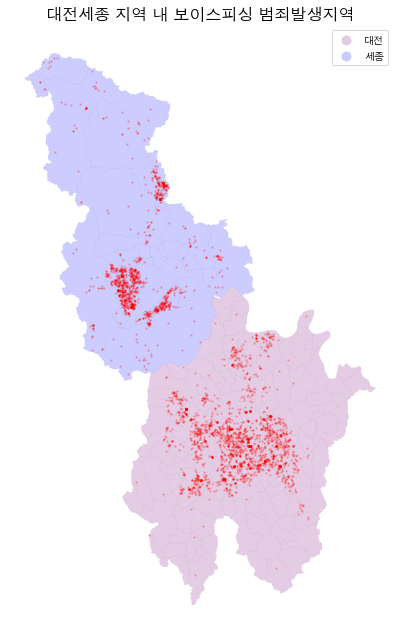

In [31]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.2, markersize=2)

ax.set_axis_off()

plt.title('대전세종 지역 내 보이스피싱 범죄발생지역', fontsize=16)
plt.savefig('plot/대전세종 지역 내 보이스피싱 범죄발생지역.png', facecolor = 'white')
plt.tight_layout()
plt.show()

In [32]:
gdf_crime.to_file('data/gdf_crime_adm.gpkg', index=False)
gdf_crime_daejeon.to_file('data/gdf_crime_adm_DJ.gpkg', index=False)
gdf_crime_sejong.to_file('data/gdf_crime_adm_SJ.gpkg', index=False)

## 외부데이터 처리

### ATM/은행 등 현금인출기 위치정보 처리
- Geocoding

In [33]:
geo_local = Nominatim(user_agent='South Korea') # 지오코더
regions = ['대전광역시','세종특별자치시']

def geocoder(region):
    df = pd.read_csv(f'data/{region} 현금인출기.csv')
    df['Y'] = 0 # 위도
    df['X'] = 0 # 경도
    
    for idx, add in enumerate(tqdm(df.ADD)):
        try:
            geo = geo_local.geocode(' '.join(add.split(' ')[0:4]))
            lat = geo.latitude
            lon = geo.longitude
        except:
            lat, lon = [0, 0]

        df.iat[idx, 2] = lat
        df.iat[idx, 3] = lon

    df.to_csv(f'data/{region} 현금인출기.csv', index=False)

In [34]:
# # Geocoding
# for region in regions:
#     geocoder(region=region)

In [35]:
# load
df_atm = pd.concat([pd.read_csv('data/대전광역시 현금인출기.csv'),pd.read_csv('data/세종특별자치시 현금인출기.csv')]).reset_index(drop=True)
df_atm = df_atm[~(df_atm.X == 0)]

df_atm = gpd.GeoDataFrame(df_atm['NAME'], geometry=gpd.points_from_xy(df_atm.X, df_atm.Y), crs='WGS84').to_crs(epsg=5181)

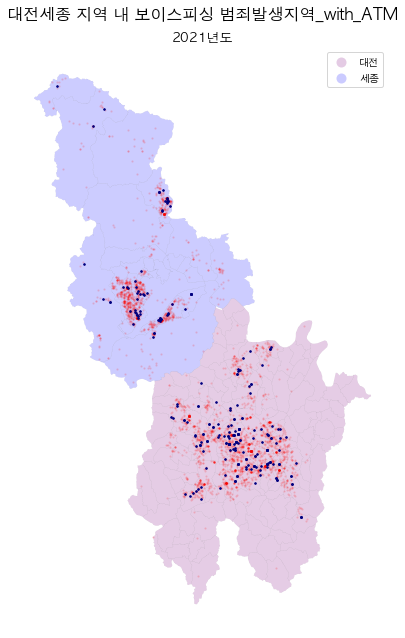

In [36]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)
df_atm.geometry.plot(ax=ax, zorder=3, color='navy', markersize=2.5)

ax.set_axis_off()

plt.suptitle('대전세종 지역 내 보이스피싱 범죄발생지역_with_ATM', fontsize=16)
plt.title('2021년도', fontsize=13)
plt.savefig('plot/대전세종 지역 내 보이스피싱 범죄발생지역_with_ATM.png', facecolor = 'white')
plt.tight_layout()
plt.show()

### 상권정보

In [37]:
df_commercial = pd.concat([pd.read_csv('data/외부데이터/소상공인시장진흥공단_상가(상권)정보_대전_202209.csv'),pd.read_csv('data/외부데이터/소상공인시장진흥공단_상가(상권)정보_세종_202209.csv')])
df_commercial = df_commercial[['상권업종대분류명','상권업종중분류명','상권업종소분류명','경도','위도']].reset_index(drop=True)
df_commercial = gpd.GeoDataFrame(df_commercial[['상권업종대분류명','상권업종중분류명','상권업종소분류명']], geometry=gpd.points_from_xy(df_commercial.경도, df_commercial.위도), crs='WGS84').to_crs(epsg=5181)

In [38]:
conv_store = df_commercial.loc[df_commercial.상권업종소분류명 == '편의점', :].reset_index(drop=True) # 편의점 위치정보
df_commercial = df_commercial.loc[df_commercial.상권업종소분류명 != '편의점', :].reset_index(drop=True)

In [39]:
commercial_cols = df_commercial.상권업종대분류명.unique()

### 버스정류장 위치정보

In [40]:
df_bus = pd.read_csv('data/외부데이터/국토교통부_전국 버스정류장 위치정보_20221012/bus.csv', usecols=['위도','경도','도시명'])
df_bus = df_bus.loc[df_bus.도시명.isin(['세종특별시','대전광역시']),:]
df_bus = gpd.GeoDataFrame(df_bus['도시명'], geometry=gpd.points_from_xy(df_bus.경도,df_bus.위도), crs='WGS84').to_crs(epsg=5181)

### 격자에 병합

In [80]:
# ATM
sjoin = gpd.sjoin(grid, df_atm[['NAME','geometry']], how='right')
grid['ATM'] = 0

for i in range(len(sjoin)):
    idx = sjoin.iat[i,0]
    grid.iat[idx, 2] += 1

print(grid.ATM.sum())

257


In [94]:
# Busstop
sjoin = gpd.sjoin(grid, df_bus[['도시명','geometry']], how='right').dropna()
grid['Bus'] = 0

for i in range(len(sjoin)):
    idx = sjoin.iat[i,0]
    grid.iat[int(idx), 3] += 1

print(grid.Bus.sum())

4348


In [97]:
# 편의점
sjoin = gpd.sjoin(grid, conv_store[['상권업종소분류명','geometry']], how='right').dropna()
grid['Conv_Store'] = 0

for i in range(len(sjoin)):
    idx = sjoin.iat[i,0]
    grid.iat[int(idx), 4] += 1

print(grid.Conv_Store.sum())

1503


In [101]:
# 상권정보
sjoin = gpd.sjoin(grid, df_commercial[['상권업종대분류명','geometry']], how='right').dropna()
grid[commercial_cols] = 0

for i in range(len(sjoin)):
    idx = sjoin.iat[i,0]
    col = sjoin.iat[i,5]
    col_idx = np.where(col == grid.columns)[0][0]
    grid.iat[int(idx), col_idx] += 1

grid[commercial_cols].sum()

생활서비스       16766
소매          26565
학문/교육        6360
음식          28581
관광/여가/오락     2179
부동산          3912
스포츠          1043
숙박            640
dtype: int64

## CENSUS DATA 병합

In [102]:
df_census = gpd.read_file('data/CENSUS/census_100M.gpkg').set_index('index')

In [103]:
# df_full = grid.set_index('GRID_1K_CD').join(df_census[df_census.columns.drop('geometry')])
# df_full.to_file('df_full.gpkg')
df_full = grid.set_index('GRID_100M_').join(df_census[df_census.columns.drop('geometry')])
df_full.to_file('df_full_100M.gpkg')

In [104]:
df_full.head(3) # Final Dataset

,geometry,ATM,Bus,Conv_Store,생활서비스,소매,학문/교육,음식,관광/여가/오락,부동산,스포츠,숙박,to_in_001,to_in_007,to_in_008
GRID_100M_,,,,,,,,,,,,,,,
다바848000,"POLYGON ((229763.414 299957.480, 229762.899 30...",0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
다바849000,"POLYGON ((229863.454 299957.995, 229862.938 30...",0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
다바850000,"POLYGON ((229963.493 299958.511, 229962.978 30...",0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
